## Problem 1
Remember from last week we discussed that skewness and kurtosis functions in statistical
packages are often biased. Is your function biased? Prove or disprove your hypothesis.

In [36]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, t, ttest_1samp

In [40]:
def test_bias(n_iter, sample_size, func, expected_value, func_name):
    np.random.seed(122)
    value = np.empty(n_iter)
    for i in range(n_iter):
        value[i] = func(np.random.normal(0, 1, sample_size))
        
    avg = np.mean(value)
    t_stat, p_value = ttest_1samp(value, expected_value)
    
    print(f"Sample size is {sample_size}.")
    print(f"Average {func_name}: {avg:.5f}")
    print(f"t-statistic: {t_stat:.5f}, p-value: {p_value:.5f}")
    
    if p_value < 0.05:
        print(f"Test the {func_name} function for bias: Reject the null hypothesis.\n")
    else:
        print(f"Test the {func_name} function for bias: Fail to reject the null hypothesis.\n")
    
sample_sizes = [100, 1000, 10000]
n_iter = 1000

for i in sample_sizes:
    test_bias(n_iter, i, kurtosis, 0, "Kurtosis")
    test_bias(n_iter, i, skew, 0, "Skewness")  

Sample size is 100.
Average Kurtosis: -0.05878
t-statistic: -3.99505, p-value: 0.00007
Test the Kurtosis function for bias: Reject the null hypothesis.

Sample size is 100.
Average Skewness: -0.01066
t-statistic: -1.40879, p-value: 0.15921
Test the Skewness function for bias: Fail to reject the null hypothesis.

Sample size is 1000.
Average Kurtosis: -0.00771
t-statistic: -1.57768, p-value: 0.11496
Test the Kurtosis function for bias: Fail to reject the null hypothesis.

Sample size is 1000.
Average Skewness: -0.00239
t-statistic: -0.94728, p-value: 0.34372
Test the Skewness function for bias: Fail to reject the null hypothesis.

Sample size is 10000.
Average Kurtosis: 0.00060
t-statistic: 0.38813, p-value: 0.69801
Test the Kurtosis function for bias: Fail to reject the null hypothesis.

Sample size is 10000.
Average Skewness: -0.00080
t-statistic: -1.03862, p-value: 0.29924
Test the Skewness function for bias: Fail to reject the null hypothesis.



## Problem 2
Fit the data in problem2.csv using OLS and calculate the error vector. Look at its distribution.
How well does it fit the assumption of normally distributed errors?

Fit the data using MLE given the assumption of normality. Then fit the MLE using the
assumption of a T distribution of the errors. Which is the best fit?

What are the fitted parameters of each and how do they compare? What does this tell us about
the breaking of the normality assumption in regards to expected values in this case?

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize

dat = pd.read_csv("problem2.csv")

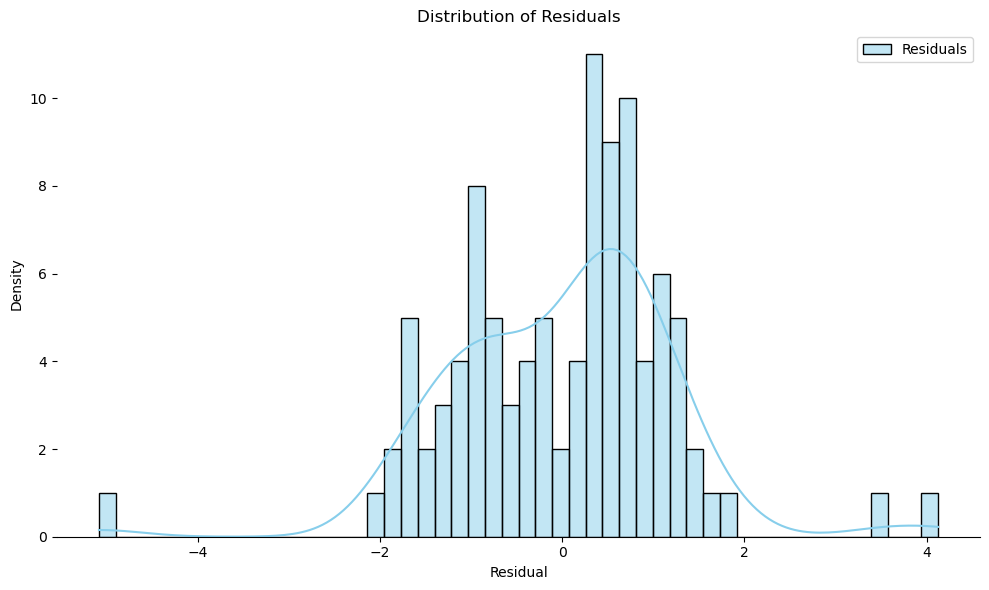

In [7]:
# Fit the OLS model
X = sm.add_constant(dat['x'])
model = sm.OLS(dat['y'], X).fit()

# Calculate the error vector
residuals = model.resid

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50, color="skyblue", label="Residuals")

sns.despine(left=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()

plt.show()

In [10]:
# Perform the Shapiro-Wilk test for normality on residuals
shapiro_result = stats.shapiro(residuals)
shapiro_result

ShapiroResult(statistic=0.9383853673934937, pvalue=0.00015388781321235)

In [26]:
# MLE
# Define the negative log-likelihood for the normal distribution
def neg_ll_normal(p):
    b0, b1, sigma = p
    neg_ll = -np.sum(stats.norm.logpdf(dat['y'], loc=b0 + dat['x']*b1, scale=sigma))
    return neg_ll

# Define the negative log-likelihood for the t distribution
def neg_ll_t(p):
    b0, b1, sigma, nu = p  # nu is the degrees of freedom for the t distribution
    neg_ll = -np.sum(stats.t.logpdf(dat['y'], df=nu, loc=b0 + dat['x']*b1, scale=sigma))
    return neg_ll

# Optimize the negative log-likelihood for the normal distribution
initial_guess_normal = [0, 0.6, 1]
result_normal = minimize(neg_ll_normal, initial_guess_normal)

# Optimize the negative log-likelihood for the t distribution
initial_guess_t = [0, 0.6, 1, 5]
result_t = minimize(neg_ll_t, initial_guess_t)

print(f"Log-likelihood using MLE given normality: -{result_normal.fun}\n")
print(f"Log-likelihood using MLE given t error distribution: -{result_t.fun}\n")

Log-likelihood using MLE given normality: -159.99209668916234

Log-likelihood using MLE given t error distribution: -155.47297041246662



In [27]:
# Calculate AIC and BIC for the normal distribution model
k_normal = len(initial_guess_normal)
n = len(dat)
aic_normal = 2 * k_normal + 2 * result_normal.fun
bic_normal = k_normal * np.log(n) + 2 * result_normal.fun

# Calculate AIC and BIC for the t distribution model
k_t = len(initial_guess_t)
aic_t = 2 * k_t + 2 * result_t.fun
bic_t = k_t * np.log(n) + 2 * result_t.fun

print(f"MLE given normality: AIC = {aic_normal}, BIC = {bic_normal}\n")
print(f"MLE given t error distribution: AIC = {aic_t}, BIC = {bic_t}\n")

MLE given normality: AIC = 325.9841933783247, BIC = 333.79970393628895

MLE given t error distribution: AIC = 318.94594082493325, BIC = 329.3666215688856



In [31]:
print(f"Estimated parameters using MLE given normality")
print(f"Intercept: {result_normal.x[0]}, slope: {result_normal.x[1]}, standard deviation: {result_normal.x[2]}\n")
print(f"Estimated parameters using MLE given t error distribution")
print(f"Intercept: {result_t.x[0]}, slope: {result_t.x[1]}, standard deviation: {result_t.x[2]}, degrees of freedom: {result_t.x[3]}\n")

Estimated parameters using MLE given normality
Intercept: 0.11983619837146034, slope: 0.6052048204621412, standard deviation: 1.1983941309451727

Estimated parameters using MLE given t error distribution
Intercept: 0.14261409575632913, slope: 0.5575717631662231, standard deviation: 0.9712659596886066, degrees of freedom: 6.276561812151229



## Problem 3
Simulate AR(1) through AR(3) and MA(1) through MA(3) processes. Compare their ACF and
PACF graphs. How do the graphs help us to identify the type and order of each process?

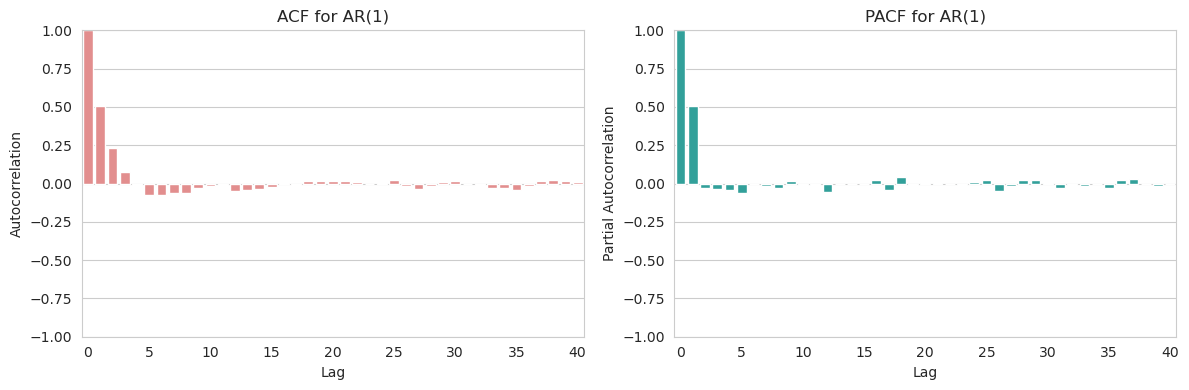

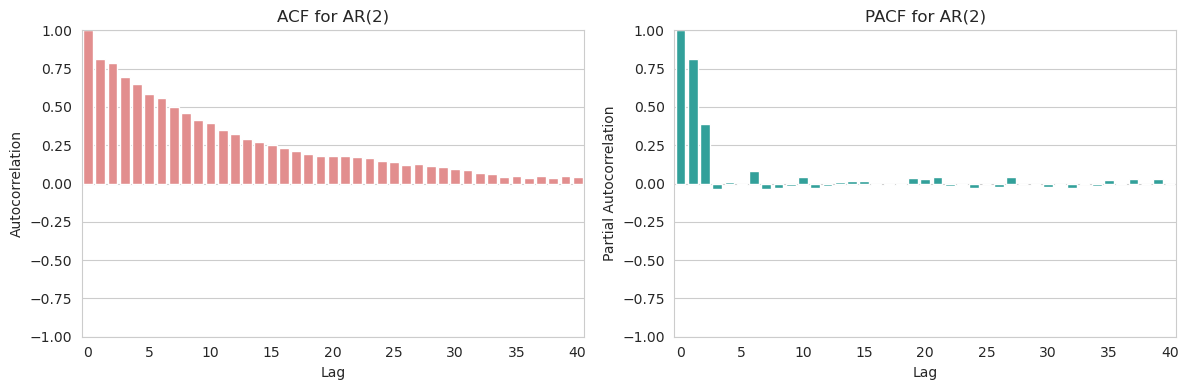

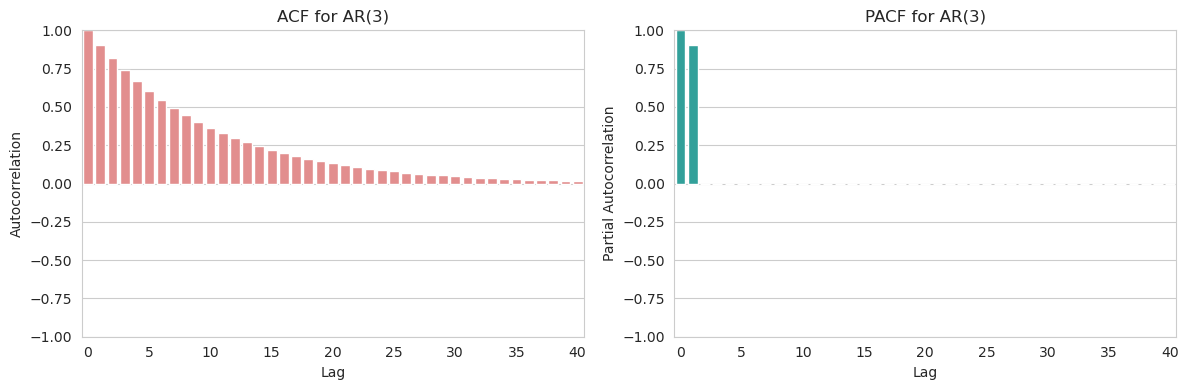

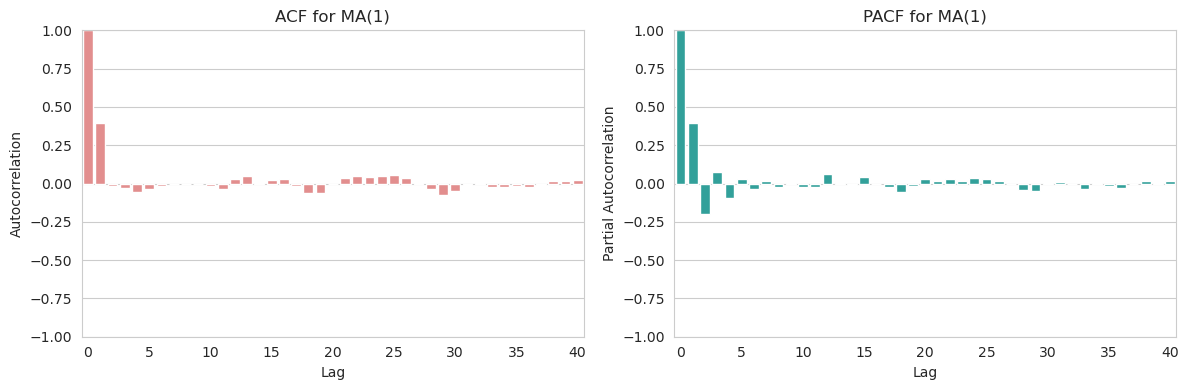

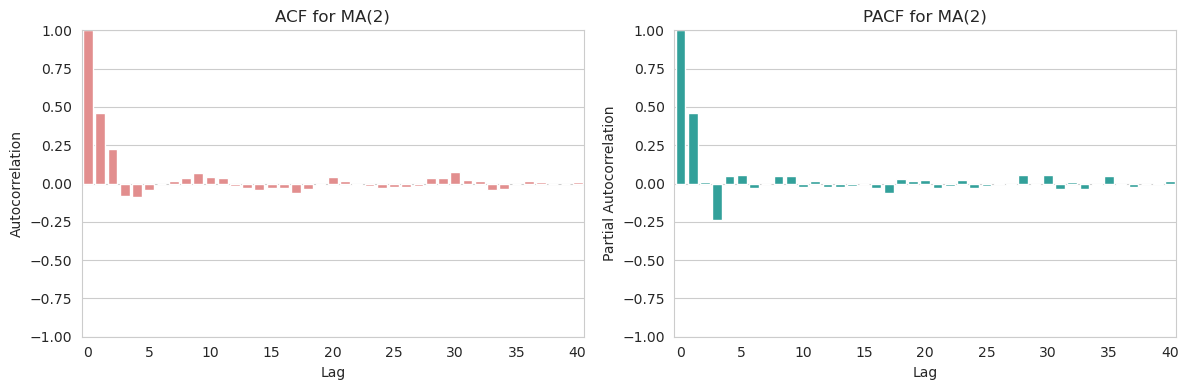

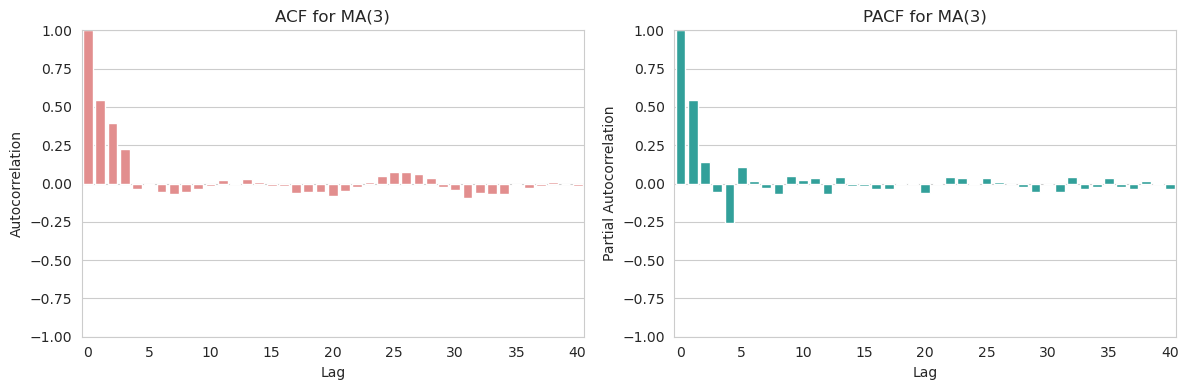

In [35]:
sns.set_style("whitegrid")

# Function to plot ACF and PACF using Seaborn
def plot_acf_pacf_seaborn(ts, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.barplot(x=np.arange(41), y=sm.tsa.acf(ts, nlags=40), ax=ax[0], color='lightcoral')
    sns.barplot(x=np.arange(41), y=sm.tsa.pacf(ts, nlags=40), ax=ax[1], color='lightseagreen')
    
    ax[0].set_title(f'ACF for {title}')
    ax[1].set_title(f'PACF for {title}')
    ax[0].set_xlabel('Lag')
    ax[1].set_xlabel('Lag')
    ax[0].set_ylabel('Autocorrelation')
    ax[1].set_ylabel('Partial Autocorrelation')
    
    # Adjust y-axis limits
    ax[0].set_ylim(-1, 1)
    ax[1].set_ylim(-1, 1)
    
    # Adjust x-axis ticks
    for axis in ax:
        axis.set_xticks(np.arange(0, 41, 5))
        axis.set_xticklabels(np.arange(0, 41, 5))
    
    plt.tight_layout()
    plt.show()

# Simulate the AR and MA processes
np.random.seed(101)  # Seed for reproducibility

# AR processes
AR1 = sm.tsa.arma_generate_sample(ar=[1, -0.5], ma=[1], nsample=1000)
AR2 = sm.tsa.arma_generate_sample(ar=[1, -0.5, -0.4], ma=[1], nsample=1000)
AR3 = sm.tsa.arma_generate_sample(ar=[1, -0.5, -0.4, -0.3], ma=[1], nsample=1000)

# MA processes
MA1 = sm.tsa.arma_generate_sample(ar=[1], ma=[1, 0.5], nsample=1000)
MA2 = sm.tsa.arma_generate_sample(ar=[1], ma=[1, 0.5, 0.4], nsample=1000)
MA3 = sm.tsa.arma_generate_sample(ar=[1], ma=[1, 0.5, 0.4, 0.3], nsample=1000)

# Plot ACF and PACF for each process
plot_acf_pacf_seaborn(AR1, "AR(1)")
plot_acf_pacf_seaborn(AR2, "AR(2)")
plot_acf_pacf_seaborn(AR3, "AR(3)")
plot_acf_pacf_seaborn(MA1, "MA(1)")
plot_acf_pacf_seaborn(MA2, "MA(2)")
plot_acf_pacf_seaborn(MA3, "MA(3)")